<a href="https://colab.research.google.com/github/thshek0/Derivation-of-Maxwell-Boltzmann-Distribution/blob/main/Maxwell_Boltzmann_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ref: https://github.com/davesspace/tutorial-thermodynamics/blob/main/particlesim.py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# plt.style.use('dark_background')  # comment out for "light" theme
plt.rcParams["font.size"] = 12
matplotlib.rcParams['animation.embed_limit'] = 2**128

# np.random.seed(0)
kB = 1.380649E-23  # Boltzmann constant

In [3]:
class Particle():
    def __init__(self, pos: np.ndarray = np.zeros(2), vel: np.ndarray = np.zeros(2), radius: float = 1E-2, mass: float = 1, color: str = "blue"):
        self.pos = pos
        self.vel = vel
        self.speed = np.sqrt(np.dot(vel, vel))
        self.radius = radius
        self.mass = mass
        self.color = color

In [4]:
class Simulation():
    def __init__(self, dt: float = 50E-6, Np: int = 20, radius: float = 1E-2, mass: float = 127*1.66E-27, T_init=293.15, X=2, Y=2):
        self.dt = dt
        self.Np = Np
        self.X = X
        self.Y = Y

        self.particles = []
        v_avg = np.sqrt(3/2*kB*T_init*2/mass)
        # random position and random angle for each particle
        # same speed for each particle initially
        for _ in range(Np):
            init_pos = np.random.uniform([-X/2, -Y/2], [X/2, Y/2], size=2)
            init_angle = np.random.uniform(0, 2*np.pi)
            init_speed = v_avg
            init_vel = init_speed * np.array([np.cos(init_angle), np.sin(init_angle)])
            self.particles.append(Particle(pos=init_pos, vel=init_vel, radius=radius, mass=mass))
        self.particles[0].color = "red"

        self.temperature = T_init
        self.average_energy = T_init * (3/2) * kB

    def collision_detection(self):
        ignore_list = []
        for particle1 in self.particles:
            # check collision with walls
            if particle1 in ignore_list:
                continue
            x, y = particle1.pos
            if ((x > self.X/2 - particle1.radius) or (x < -self.X/2+particle1.radius)):
                particle1.vel[0] *= -1
            if ((y > self.Y/2 - particle1.radius) or (y < -self.Y/2+particle1.radius)):
                particle1.vel[1] *= -1

            # check collisions with other particles
            # if yes, ignore further computation of the collided particle
            for particle2 in self.particles:
                if id(particle1) == id(particle2):
                    continue
                m1, m2, r1, r2, v1, v2 = particle1.mass, particle2.mass, particle1.pos, particle2.pos, particle1.vel, particle2.vel
                if np.dot(r1-r2, r1-r2) <= (particle1.radius + particle2.radius)**2:
                    v1_new = v1 - 2*m2 / \
                        (m1+m2) * np.dot(v1-v2, r1-r2) / \
                        np.dot(r1-r2, r1-r2)*(r1-r2)
                    v2_new = v2 - 2*m1 / \
                        (m1+m2) * np.dot(v2-v1, r2-r1) / \
                        np.dot(r2-r1, r2-r1)*(r2-r1)
                    particle1.vel = v1_new
                    particle2.vel = v2_new
                    ignore_list.append(particle2)

    def increment(self):
        # update position and velocity in each frame
        self.collision_detection()
        for particle in self.particles:
            particle.pos += self.dt * particle.vel
            particle.speed = np.sqrt(np.dot(particle.vel, particle.vel))

        # not necessary: checking purpose
        total_energy = 0
        for particle in self.particles:
            total_energy += 0.5 * particle.mass * particle.speed**2
        self.average_energy = total_energy / self.Np
        self.temperature = self.average_energy*(2/3)/kB

In [5]:
X, Y = 2, 2
Np = 200
mass = 127*1.66E-27
radius = 1E-2
T_init = 293.15

sim = Simulation(Np=Np, T_init=T_init, mass=mass, radius=radius)

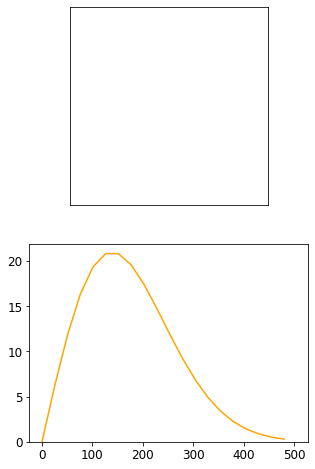

In [6]:
n_avg = 100

# create figure with 2 subplots (simulation and graph)
fig, (ax, ax2) = plt.subplots(figsize=(5, 8), nrows=2)
ax.set_xticks([]), ax.set_yticks([])
ax.set_aspect("equal")

# vs = np.arange(0, 500, 25)
max_speed = max([i.speed for i in sim.particles])
vs = np.linspace(0, max_speed*2, 20)

scatter = ax.scatter([], [], s=sim.X*sim.Y*(fig.dpi*radius)**2)
T_txt = ax.text(sim.X/2*0.5, sim.Y/2*0.92, s="")

bar = ax2.bar(vs, [0]*len(vs), width=0.9 *
                np.gradient(vs), align="edge", alpha=0.8)

# theo = ax2.plot(vs, 25*sim.Np*(mass/(2*np.pi*kB*sim.temperature))**(3/2) * 4 *
#                 np.pi*vs**2 * np.exp(-mass*vs**2/(2*kB*sim.temperature)), color="orange")
a = mass/(kB*sim.temperature)
theo = ax2.plot(vs, (max_speed*2/20)*sim.Np*a* vs * np.exp(-a*vs**2/2), color="orange")

freqs_matrix = np.tile((np.histogram([particle.speed for particle in sim.particles], bins=vs)[
    0].astype(float)), (n_avg, 1))

def init():
    # simulation figure: dimension X x Y, centre (0, 0)
    ax.set_xlim(-sim.X/2, sim.X/2)
    ax.set_ylim(-sim.Y/2, sim.Y/2)

    # graph figure: x-axis: speed, y-axis: # of particles
    ax2.set_xlim(vs[0], vs[-1])
    ax2.set_ylim(0, sim.Np)
    ax2.set(xlabel="Particle Speed (mass/s)", ylabel="# of particles")
    return (scatter, *bar.patches)

def update(frame):
    sim.increment()

    T_txt.set_text(f"{sim.temperature:.2f} K")

    freqs, bins = np.histogram([particle.speed for particle in sim.particles], bins=vs)
    freqs_matrix[frame % n_avg] = freqs
    freqs_mean = np.mean(freqs_matrix, axis=0)
    freqs_max = np.max(freqs_mean)

    for rect, height in zip(bar.patches, freqs_mean):
        rect.set_height(height)

    if np.abs(freqs_max - ax2.get_ylim()[1]) > 10:
        ax2.set_ylim(0, 5 + ax2.get_ylim()[1] + (freqs_max - ax2.get_ylim()[1]))
        fig.canvas.draw()

    scatter.set_offsets(np.array([particle.pos for particle in sim.particles]))
    scatter.set_color([particle.color for particle in sim.particles])
    return (scatter, *bar.patches, T_txt)

In [7]:
ani = FuncAnimation(
    fig,
    update,
    frames=range(1000),
    init_func=init,
    blit=True,
    interval=30,
    repeat=False
)

In [10]:
plt.show()

In [12]:
from IPython.display import HTML
HTML(ani.to_jshtml())

In [8]:
HTML(ani.to_html5_video())